**Goal**: To build an AI agent with LangGraph framework that takes a meeting audio file as input and returns a structured summary i.e Attendees, Key Discussion Points, Action Items, Decisions Made.
* *Note: Uploaded file should be any prominent audio file like (`.wav`, `.mp3`, `.m4a`) and currently supports only english language*



**Install packages**

In [ ]:
!pip install langgraph langchain mistralai gradio --quiet
!pip install faster-whisper --quiet


**Import packages**

In [ ]:
import json
import os
import requests
from faster_whisper import WhisperModel
from typing import TypedDict
from langgraph.graph import StateGraph

**LLM model used is mistral**

In [ ]:
os.environ["MISTRAL_API_KEY"] = "MISTRAL_API_KEY"

**Detailed architecture**

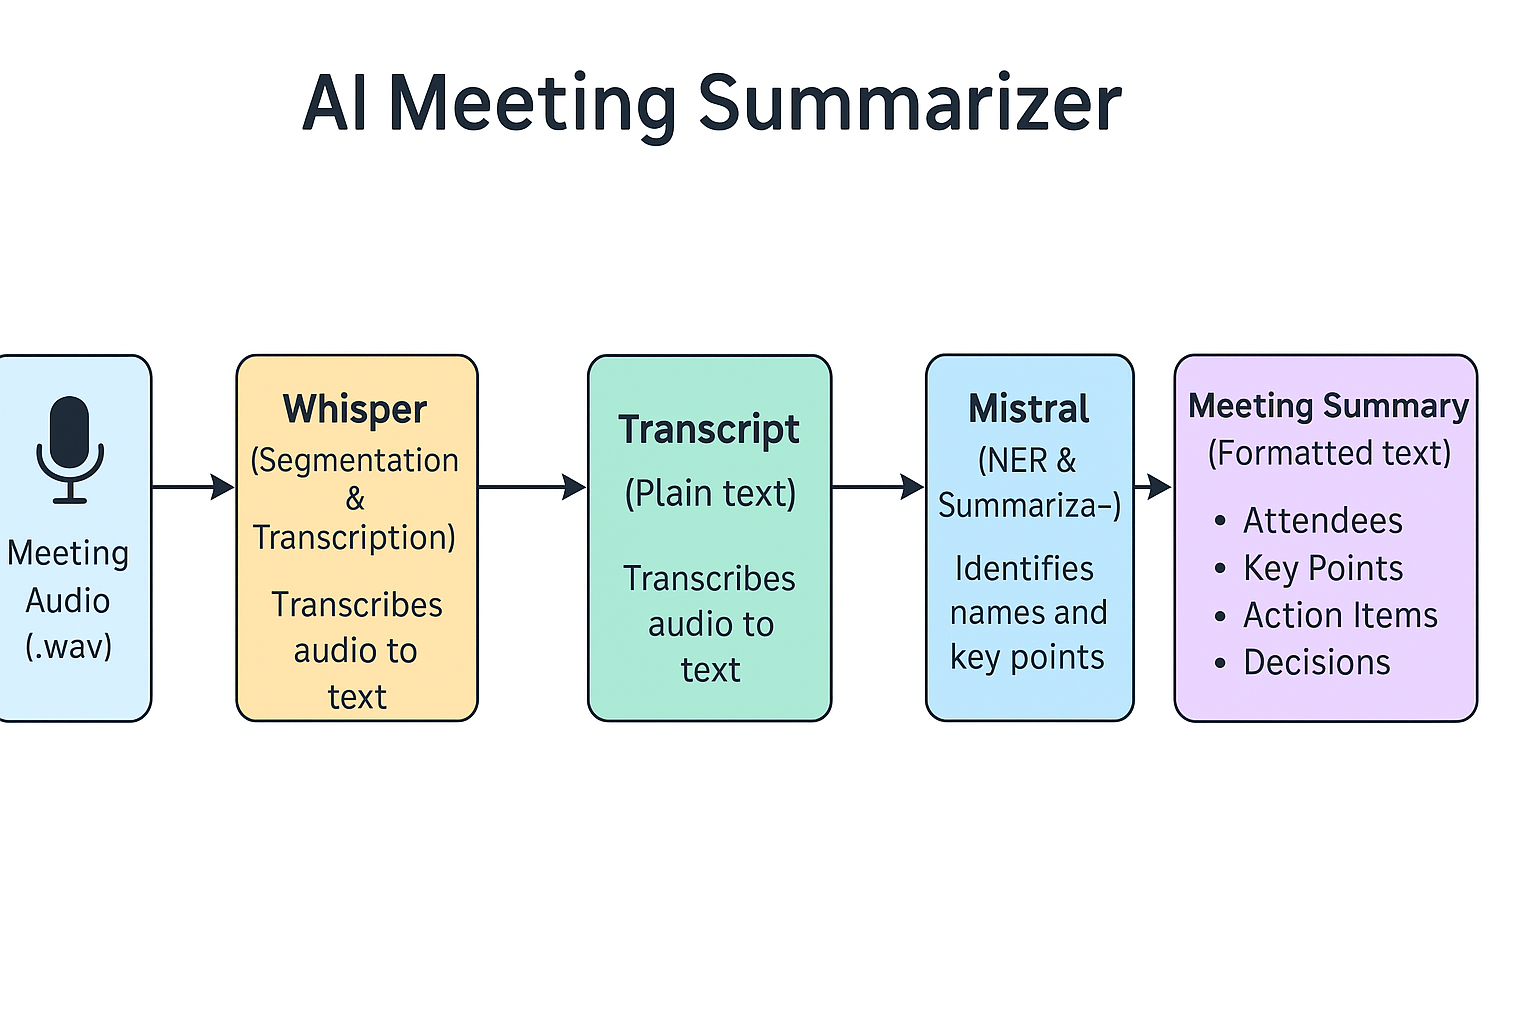

In [1]:
from IPython.display import Image, display

# If you uploaded it to Colab directly
image_path = "/content/Architecture.png"

display(Image(filename=image_path))


**Defining the State**

In [ ]:
class State(TypedDict):
    file_path: str
    transcript: str
    summary_json: dict
    final_output: str

**Transcribe the audio**

In [ ]:
def transcribe_audio(state: State) -> State:
    model = WhisperModel("base", compute_type="float32")
    segments, _ = model.transcribe(state["file_path"], beam_size=5, language="en")

    transcript = " ".join(segment.text.strip() for segment in segments)
    return {**state, "transcript": transcript}


**Summarize the transcript**

In [ ]:
import requests

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
MODEL = "mistral-large-latest"

def summarize_transcript(state: State) -> State:
    prompt = f"""
You are an AI assistant summarizing meeting transcripts.

Extract the following:
1. Attendees (Names only, if possible)
2. Key Discussion Points (bullet format)
3. Action Items (with owner and deadline, if mentioned)
4. Decisions Made (if any)

Respond in this format:
{{
  "attendees": [...],
  "key_points": [...],
  "action_items": [...],
  "decisions": [...]
}}

Transcript:
\"\"\"{state['transcript']}\"\"\"
"""
    res = requests.post(
        "https://api.mistral.ai/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {MISTRAL_API_KEY}",
            "Content-Type": "application/json"
        },
        json={
            "model": MODEL,
            "messages": [{"role": "user", "content": prompt}],
            "temperature": 0.3
        }
    )
    content = res.json()['choices'][0]['message']['content']
    return {**state, "summary_json": eval(content)}


**Format the summary**

In [ ]:
def format_output(state: State) -> State:
    summary = state["summary_json"]
    formatted = "📌 Attendees:\n" + "\n".join(f"- {name}" for name in summary["attendees"]) + "\n\n"
    formatted += "💬 Key Points:\n" + "\n".join(f"- {pt}" for pt in summary["key_points"]) + "\n\n"
    formatted += "✅ Action Items:\n" + "\n".join(f"- {item}" for item in summary["action_items"]) + "\n\n"
    formatted += "📎 Decisions:\n" + "\n".join(f"- {d}" for d in summary["decisions"])
    return {**state, "final_output": formatted}


**Build the LangGraph nodes and edges**

In [ ]:
from langgraph.graph import StateGraph

builder = StateGraph(State)
builder.add_node("transcribe_audio", transcribe_audio)
builder.add_node("summarize_transcript", summarize_transcript)
builder.add_node("format_output", format_output)

# Link nodes
builder.set_entry_point("transcribe_audio")
builder.add_edge("transcribe_audio", "summarize_transcript")
builder.add_edge("summarize_transcript", "format_output")

graph = builder.compile()


**Visualizing the graph**

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Testing the agent and printing the workflow**

In [ ]:
initial_state = {
    "file_path": "/content/Meeting1.wav"  # Or the actual name you uploaded
}

final_state = graph.invoke(initial_state)

# Show the full structured JSON output
from pprint import pprint
pprint(final_state["summary_json"])

# If you also formatted it into text in `format_output`
print("\n--- Final Summary Text ---\n")
print(final_state.get("final_output", "No final_output found"))


**Structured summary**

In [ ]:
print(final_state["final_output"])

📌 Attendees:
- Carol Fletcher
- Peter Morgan
- Frank Maffer
- Mike Reinhardt
- Trudy Finch

💬 Key Points:
- Introduction of new team member Trudy Finch
- Purchase approval for cheaper option with quality and guarantee assurance
- Production figures update: up by 2% on product streams 1 and 2, down by 0.5% on product stream 3
- Recruitment programme summary: 10 new hires, 9 completed probation
- Discussion on Alpha system implementation: phased rollout vs. swift implementation
- Training programme for Alpha system
- Internet usage policy during lunch breaks
- Charity cycle ride involvement

✅ Action Items:
- {'owner': 'Peter Morgan', 'task': 'Purchase cheaper option with quality and guarantee assurance', 'deadline': 'Not specified'}
- {'owner': 'Mike Reinhardt', 'task': 'Update on production figures for last quarter', 'deadline': 'Not specified'}
- {'owner': 'Trudy Finch', 'task': 'Summarize recent recruitment programme', 'deadline': 'Not specified'}
- {'owner': 'HR', 'task': 'Develop a

**Conclusion**

The AI agent successfully summarized the meeting audio by transcribing it using Whisper, understanding the content through LLMs (like Mistral), and producing a structured summary including Attendees, Key Points, Action Items, and Decisions Made.